# Import Libs

In [128]:
# Import general functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import lib for saving model and encoder
import os
import pickle

# Import preprocessing functions
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Import metrics functions
from sklearn import metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, recall_score, precision_score, f1_score # For classifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # For regression

In [102]:
build_path = "build_files/"

# Preprocessing

In [103]:
# Import dataset
data = pd.read_excel('src/dataset_norm.xlsx')

# Define minimal mark
min_mark = 4

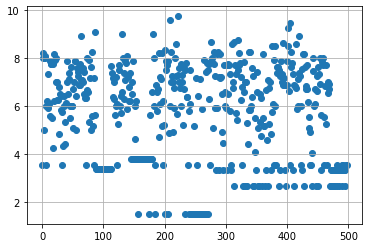

In [104]:
# Output distribution of scores
x = range(len(data['Средний балл']))
y = data['Средний балл']

plt.scatter(x, y)
plt.grid()
plt.show()

NOTE: lines in graph illustrate custom increase the number of not pass students.
That trick were done for better model training. It helps to increase accuracy metricks of models

Lets find out how many students did not pass the exams

In [105]:
def counter_print():
    passed = 0
    not_passed = 0
    res = 0
    for mark in data['Средний балл']:
        if mark >= min_mark:
            passed += 1
        elif mark < min_mark:
            not_passed += 1
        res += 1
    print(f"TOTAL: {res}\nPassed: {passed}\nNot pas: {not_passed}")

counter_print()

TOTAL: 498
Passed: 341
Not pas: 157


In [106]:
# Replase mark of student by belonging to the class of successfully passed
data['Сдал'] = pd.cut(x=data['Средний балл'], bins=[0, min_mark, 10], labels=[0, 1])
data.drop(['Средний балл'], axis = 1, inplace= True)

# Drop indicators which are not connected with extracurricular activities
data.drop(['Дата прохождения теста',
            '15.Образование Ваших родителей?', 
            '3.С какими оценками Вы закончили школу?',
            '4.Ходили ли Вы на подготовительные курсы перед поступлением в вуз?',
            '7.Какая у Вас семья?',
            '10.Получали ли Вы стипендию? (в течение последнего года)',
            '11.Оцените, как Вам нравится учиться?',
            '13.На какие средства Вы живете?',
            '5.Брали ли Вы академический отпуск?',
            '17.Укажите Ваше семейное положение.',
            '12.Каковы условия Вашего проживания?'
            ],
            axis = 1, inplace = True)

Dataset with concern questions

In [107]:
data.head()

,Учащийся,16.Работаете ли Вы?,14.Увлекаетесь ли Вы спортом?,9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?,8.Как много Вы пропускаете аудиторных занятий?,6.Бывают ли у Вас долги по экзаменам/зачетам?,"2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?",1.Участвуете ли Вы в олимпиадах?,Сдал
0,Кайнов Кирилл Анатольевич,Нет,"да, хожу на фитнес или в тренажерный зал",От 1 до 3 часов в день,Среднее количество пропусков,1-2 раза в семестр,нет,Нет,0
1,Матутин Василий Андреевич,Нет,"нет, не занимаюсь",Более 3 часов в день,Не пропускаете,Нет,нет,"Нет, но собираюсь в этом году",1
2,Константинов Александр Михайлович,Да,"нет, не занимаюсь",Готовлюсь только перед занятиями,Регулярно пропускаете,Всегда,нет,Нет,1
3,Кудакаев Руслан Фаритович,Нет,"нет, не занимаюсь",Более 3 часов в день,Не пропускаете,Нет,нет,Нет,1
4,Балов Илья Сергеевич,Нет,"да, занимаюсь шахматами/шашками;нет, не занимаюсь",Более 3 часов в день,Среднее количество пропусков,1-2 раза в год,нет,Да,1


Split our data in 3 parts for train, test and validation

In [108]:
def create(path):
    if not os.path.exists(path):
        os.mkdir(path)

In [109]:
# Save hash of student name
name_hash = []


def train_test_val_split(test_ratio, validation_ratio):
# That part index all names to use them in validation part
    global name_hash
    for idx, name in enumerate(data['Учащийся']):
        name_hash.append((idx, name))
        data.loc[idx,'Учащийся'] = idx

# Replace all text output to index
    label_encoder = LabelEncoder()
    label_data = data.copy()
    s = (label_data.dtypes == 'object')
    object_cols = list(s[s].index)
    create(build_path)
    for col in object_cols:
        label_encoder.fit(label_data[col])
        label_data[col] = label_encoder.transform(label_data[col])
        # Save lable encouder hash to separate files to use them in future if need
        file_name = f'{build_path}/{col.replace("/", "-")}_class_linear_encoder.npy'
        f = open(file_name, 'w+')
        np.save(file_name, label_encoder.classes_)
        f.close()


# Split dataset
# NOTE: To fix split selections use random_state=42 parameter
    size = label_data.shape[0]
    validation_ratio = (validation_ratio * size) / (size * (1 - test_ratio))

    X_train, X_test, y_train, y_test = train_test_split(label_data.drop('Сдал', axis = 1), 
                                                        label_data['Сдал'], 
                                                        test_size=test_ratio)

    X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                      y_train, 
                                                      test_size=validation_ratio)

# Output X_train.iloc[:,1:] delete student hash from training and testing selections
    return X_train.iloc[:,1:], X_test.iloc[:,1:], X_val, y_train, y_test, y_val

In [110]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(test_ratio=0.25, validation_ratio=0.05)

# Model variants
In that part I will choose the classification model which will predict if student pass exams successfully or not

## Metrics Functions

In [111]:
def classification_quality(y_test, y_pred):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("F1:", f1_score(y_test, y_pred, average='macro', labels=np.unique(y_pred)))
    print("Weighted Recall:", (precision_recall_fscore_support(y_test, y_pred, average='macro')))

In [112]:
# For historical reason
def regression_quality(y_test, y_pred):
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("RMSE:", mean_squared_error(y_test, y_pred)**(1/2))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R2:", r2_score(y_test, y_pred))

In [113]:
metrics_list = ['Accuracy', 'Balanced Accuracy', 'Recall', 'Precision', 'F1', 'MSE', 'RMSE', 'MAE', 'R2']
model_array = []
output_array = []

def compilance_print(model, y_test, y_pred, model_flag):
    temp_array = []
    if model_flag == 'cls': # Classifier
        temp_array.append(accuracy_score(y_test, y_pred))
        temp_array.append(balanced_accuracy_score(y_test, y_pred))
        temp_array.append(recall_score(y_test, y_pred, average='macro'))
        temp_array.append(precision_score(y_test, y_pred, average='macro'))
        temp_array.append(f1_score(y_test, y_pred, average='macro', labels=np.unique(y_pred)))
        for _ in range(4): temp_array.append(None)
    
    # For historical reason
    elif model_flag == 'reg': # Regression
        for _ in range(5): temp_array.append(None)
        temp_array.append(mean_squared_error(y_test, y_pred))
        temp_array.append(mean_squared_error(y_test, y_pred)**(1/2))
        temp_array.append(mean_absolute_error(y_test, y_pred))
        temp_array.append(r2_score(y_test, y_pred))
    else: 
        print('Error')
        for _ in range(len(metrics_list)): temp_array.append(None)

    model_indx = -1
    flag = 1
    for indx, _model in enumerate(model_array):
        if _model == model:
            model_indx = indx
            flag = 0
    if flag:
        output_array.append([0]* len(metrics_list))
        model_indx = len(model_array)
        model_array.append(model)
    for indx, el in enumerate(temp_array):
        output_array[model_indx][indx] = el

In [114]:
def graph_show(model, X, y):
    metrics.plot_confusion_matrix(model, X, y)
    metrics.plot_roc_curve(model, X, y)  
    plt.show()

## Classifier

### Perception Classifier Model

In [115]:
from sklearn.linear_model import Perceptron
Perc = Perceptron()
Perc.fit(X_train, y_train)

y_pred = Perc.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('Perceptron', y_test, y_pred, 'cls')

Accuracy: 0.8
Recall: 0.7205882352941176
Precision: 0.8
F1: 0.7401247401247402
Weighted Recall: (0.8, 0.7205882352941176, 0.7401247401247402, None)


### Random Forest Classifier Model

In [116]:
from sklearn.ensemble import RandomForestClassifier
RanF = RandomForestClassifier()
RanF.fit(X_train, y_train)

y_pred = RanF.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('RandomForest', y_test, y_pred, 'cls')

Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1: 1.0
Weighted Recall: (1.0, 1.0, 1.0, None)


### Gradient Boosting Classifier Model

In [117]:
from sklearn.ensemble import GradientBoostingClassifier
GraB = GradientBoostingClassifier()
GraB.fit(X_train, y_train)

y_pred = GraB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('GradientBoosting', y_test, y_pred, 'cls')

Accuracy: 0.976
Recall: 0.9823529411764707
Precision: 0.9651162790697674
F1: 0.9729456749152298
Weighted Recall: (0.9651162790697674, 0.9823529411764707, 0.9729456749152298, None)


### MultinomialNB Classifier Model

In [118]:
from sklearn.naive_bayes import MultinomialNB
MulNB = MultinomialNB()
MulNB.fit(X_train, y_train)

y_pred = MulNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('MultinomialNB', y_test, y_pred, 'cls')

Accuracy: 0.848
Recall: 0.861764705882353
Precision: 0.8259141494435612
F1: 0.8358559679314397
Weighted Recall: (0.8259141494435612, 0.861764705882353, 0.8358559679314397, None)


### ComplementNB Classifier Model

In [119]:
from sklearn.naive_bayes import ComplementNB
ComNB = ComplementNB()
ComNB.fit(X_train, y_train)

y_pred = ComNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('ComplementNB', y_test, y_pred, 'cls')

Accuracy: 0.84
Recall: 0.8823529411764706
Precision: 0.8333333333333333
F1: 0.8333333333333333
Weighted Recall: (0.8333333333333333, 0.8823529411764706, 0.8333333333333333, None)


### GaussianNB Classifier Model

In [120]:
from sklearn.naive_bayes import GaussianNB
GaNB = GaussianNB()
GaNB.fit(X_train, y_train)

y_pred = GaNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('GaussianNB', y_test, y_pred, 'cls')

Accuracy: 0.912
Recall: 0.9352941176470588
Precision: 0.892156862745098
F1: 0.9049692445918862
Weighted Recall: (0.892156862745098, 0.9352941176470588, 0.9049692445918862, None)


### BernoulliNB Classifier Model

In [129]:
from sklearn.naive_bayes import BernoulliNB
BerNB = BernoulliNB()
BerNB.fit(X_train, y_train)

y_pred = BerNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('BernoulliNB', y_test, y_pred, 'cls')

Accuracy: 0.912
Recall: 0.9352941176470588
Precision: 0.892156862745098
F1: 0.9049692445918862
Weighted Recall: (0.892156862745098, 0.9352941176470588, 0.9049692445918862, None)


### SVC Classifier Model

In [130]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('SVC', y_test, y_pred, 'cls')

Accuracy: 0.952
Recall: 0.9647058823529412
Precision: 0.9347826086956521
F1: 0.9468235961429381
Weighted Recall: (0.9347826086956521, 0.9647058823529412, 0.9468235961429381, None)


### LinearSVC Classifier Model

In [131]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC()
lsvc.fit(X_train, y_train)

y_pred = lsvc.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('LinearSVC', y_test, y_pred, 'cls')

Accuracy: 0.896
Recall: 0.8970588235294118
Precision: 0.875
F1: 0.8841354723707664
Weighted Recall: (0.875, 0.8970588235294118, 0.8841354723707664, None)


/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### DecisionTreeClassifier Model

Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1: 1.0
Weighted Recall: (1.0, 1.0, 1.0, None)


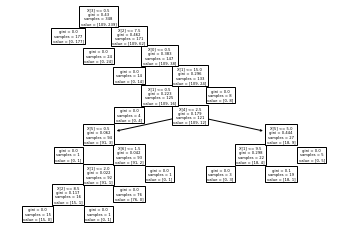

In [132]:
from sklearn.tree import DecisionTreeClassifier
dtr = DecisionTreeClassifier()
dtr.fit(X_train, y_train)

y_pred = dtr.predict(X_test)

plot_tree(dtr)

classification_quality(y_test, y_pred)
compilance_print('DecisionTreeClassifier', y_test, y_pred, 'cls')

### ExtraTreeClassifier Model

Accuracy: 0.968
Recall: 0.9764705882352941
Precision: 0.9545454545454546
F1: 0.9641422834193918
Weighted Recall: (0.9545454545454546, 0.9764705882352941, 0.9641422834193918, None)


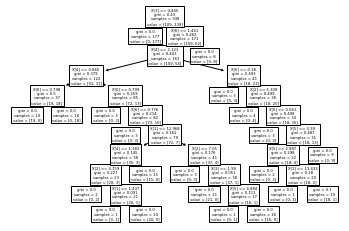

In [133]:
from sklearn.tree import ExtraTreeClassifier
extr = ExtraTreeClassifier()
extr.fit(X_train, y_train)

y_pred = extr.predict(X_test)

plot_tree(extr)
classification_quality(y_test, y_pred)
compilance_print('ExtraTreeClassifier', y_test, y_pred, 'cls')

### MLPClassifier Model

In [134]:
from sklearn.neural_network import MLPClassifier
MLPCl = MLPClassifier()
MLPCl.fit(X_train, y_train)

y_pred = MLPCl.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('MLPClassifier', y_test, y_pred, 'cls')

Accuracy: 0.936
Recall: 0.9529411764705882
Precision: 0.9166666666666667
F1: 0.9298540965207631
Weighted Recall: (0.9166666666666667, 0.9529411764705882, 0.9298540965207631, None)


/Users/alexgiving/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Matrix
That table helps to understand which model is better for my work

In [135]:
pd.DataFrame(index=metrics_list, columns=model_array, data=np.array(pd.DataFrame(output_array).T))

,Perceptron,RandomForest,GradientBoosting,MultinomialNB,ComplementNB,GaussianNB,BernoulliNB,SVC,LinearSVC,ExtraTreeClassifier,MLPClassifier,DecisionTreeClassifier
Accuracy,0.8,1.0,0.976,0.848,0.84,0.912,0.912,0.952,0.896,0.968,0.936,1.0
Balanced Accuracy,0.720588,1.0,0.982353,0.861765,0.882353,0.935294,0.935294,0.964706,0.897059,0.976471,0.952941,1.0
Recall,0.720588,1.0,0.982353,0.861765,0.882353,0.935294,0.935294,0.964706,0.897059,0.976471,0.952941,1.0
Precision,0.8,1.0,0.965116,0.825914,0.833333,0.892157,0.892157,0.934783,0.875,0.954545,0.916667,1.0
F1,0.740125,1.0,0.972946,0.835856,0.833333,0.904969,0.904969,0.946824,0.884135,0.964142,0.929854,1.0
MSE,None,None,None,None,None,None,None,None,None,None,None,None
RMSE,None,None,None,None,None,None,None,None,None,None,None,None
MAE,None,None,None,None,None,None,None,None,None,None,None,None
R2,None,None,None,None,None,None,None,None,None,None,None,None


# Model result

In [136]:
my_model = dtr  # My own prefix of DecisionTreeClassifier

I decided to use DecisionTree Classifier model due to its metrix

In [137]:
# save the model to disk
filename = f'{build_path}/DecisionTreeClassifier.sav'
pickle.dump(my_model, open(filename, 'wb'))

#my_model = pickle.load(open(filename, 'rb'))

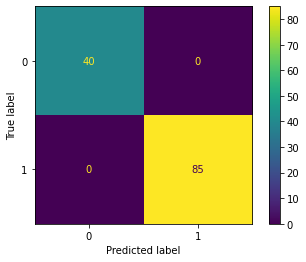

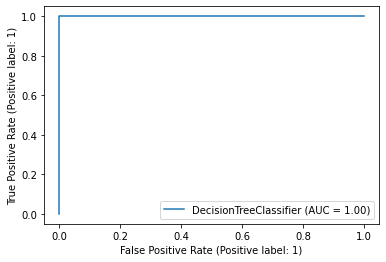

In [138]:
# Output ROC/AUC graphs
graph_show(my_model, X_test, y_test)

That metrics shows the accuracy of model. As we can see that models return very few False-Positive and True-Negative errors

# Validation

In [139]:
# Get predicted results of validation selection
# NOTE: Validation selection was not used for training model thus the results are objective
# Also X_val.iloc[:,1:] used for hiding from model hash of students names
y_pred_val = my_model.predict(X_val.iloc[:,1:])

These functions allow to output results of validation

In [140]:
def print_with_name():
    print(f'Студент {name_hash[X_val.iloc[i, 0]][1]} предположительно {"сдал(а)" if y_pred_val[i] == 1 else "не сдал(а)"}, в жизни {"сдал(а)" if y_val.iloc[i] == 1 else "не сдал(а)"}')

def print_with_id():
    print(f'Студент №{i+1} предположительно {"сдал(а)" if y_pred_val[i] == 1 else "не сдал(а)"}, в жизни {"сдал(а)" if y_val.iloc[i] == 1 else "не сдал(а)"}')

In [141]:
error_counter = 0
total = 0
for i in range(len(y_pred_val)):
    if y_pred_val[i] != y_val.iloc[i] == 1:
        error_counter += 1
    total += 1
    print_with_id()
print(f'There were {error_counter} from {total} error(s)!')

Студент №1 предположительно сдал(а), в жизни сдал(а)
Студент №2 предположительно не сдал(а), в жизни не сдал(а)
Студент №3 предположительно сдал(а), в жизни сдал(а)
Студент №4 предположительно сдал(а), в жизни сдал(а)
Студент №5 предположительно не сдал(а), в жизни сдал(а)
Студент №6 предположительно сдал(а), в жизни сдал(а)
Студент №7 предположительно не сдал(а), в жизни не сдал(а)
Студент №8 предположительно сдал(а), в жизни сдал(а)
Студент №9 предположительно сдал(а), в жизни сдал(а)
Студент №10 предположительно не сдал(а), в жизни не сдал(а)
Студент №11 предположительно сдал(а), в жизни сдал(а)
Студент №12 предположительно сдал(а), в жизни сдал(а)
Студент №13 предположительно сдал(а), в жизни сдал(а)
Студент №14 предположительно не сдал(а), в жизни не сдал(а)
Студент №15 предположительно сдал(а), в жизни сдал(а)
Студент №16 предположительно сдал(а), в жизни сдал(а)
Студент №17 предположительно не сдал(а), в жизни не сдал(а)
Студент №18 предположительно сдал(а), в жизни сдал(а)
Студ

# Validation with my answers

In [142]:
my_questions = ["Учащийся", "16.Работаете ли Вы?", "14.Увлекаетесь ли Вы спортом?", 
                "9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?",
                "8.Как много Вы пропускаете аудиторных занятий?", "6.Бывают ли у Вас долги по экзаменам/зачетам?", 
                "2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?", "1.Участвуете ли Вы в олимпиадах?" ]


my_answers =    [
                "Трутнев Алексей Игоревич",                 # Учащийся
                "Да",                                       # 16.Работаете ли Вы?
                "да, хожу на фитнес или в тренажерный зал", # 14.Увлекаетесь ли Вы спортом?
                "Готовлюсь только перед занятиями",         # 9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?
                "Не пропускаете",                           # 8.Как много Вы пропускаете аудиторных занятий?
                "Нет",                                      # 6.Бывают ли у Вас долги по экзаменам/зачетам?
                "нет",                                      # 2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?
                "Нет",                                      # 1.Участвуете ли Вы в олимпиадах?
                ]


df = pd.DataFrame(data=[my_answers], columns=my_questions)

for col in pd.DataFrame(df.iloc[:,1:]).columns:                             # Iterate by df without name
    encoder = LabelEncoder()
    filename = f"{build_path}/{str(col).replace('/', '-')}_class_linear_encoder.npy" 
    encoder.classes_ = np.load(filename, allow_pickle=True)                 # Import encouder fit data
    df[col] = encoder.transform(df[col])


y_pred_my = my_model.predict(df.iloc[:,1:])     # Without name
print(f'{df.iloc[0,0]} предположительно {"сдал(а)" if y_pred_my == 1 else "не сдал экзамен"}')

Трутнев Алексей Игоревич предположительно сдал(а)


# Correlation matrix

In [ ]:
def exists(path):
    try:
        os.stat(path)
    except OSError:
        return False
    return True

In [ ]:
# Replace all text output to index
# Used for outputing correlation matrix
label_encoder = LabelEncoder()
label_data = data.copy()

label_data = label_data.iloc[:,1:]
s = (label_data.dtypes == 'object')
object_cols = list(s[s].index)

for col in object_cols:
    filename = f"{build_path}/{col.replace('/', '-')}_class_linear_encoder.npy"
    if exists(filename):
        label_encoder.classes_ = np.load(filename, allow_pickle=True)
    else: 
        label_encoder.fit(data[col])
#   always:
    label_data[col] = label_encoder.transform(label_data[col])


# Creating correlation matrix
rs = np.random.RandomState(0)
corr = label_data.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,16.Работаете ли Вы?,14.Увлекаетесь ли Вы спортом?,9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?,8.Как много Вы пропускаете аудиторных занятий?,6.Бывают ли у Вас долги по экзаменам/зачетам?,"2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?",1.Участвуете ли Вы в олимпиадах?
16.Работаете ли Вы?,1.000000,0.089090,0.076887,-0.039203,-0.037762,-0.065567,-0.041863
14.Увлекаетесь ли Вы спортом?,0.089090,1.000000,-0.101621,-0.177372,0.047282,-0.109349,-0.005452
9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?,0.076887,-0.101621,1.000000,0.361126,-0.158651,-0.010636,-0.047685
8.Как много Вы пропускаете аудиторных занятий?,-0.039203,-0.177372,0.361126,1.000000,-0.387457,-0.050922,-0.084693
6.Бывают ли у Вас долги по экзаменам/зачетам?,-0.037762,0.047282,-0.158651,-0.387457,1.000000,0.031436,0.180910
"2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?",-0.065567,-0.109349,-0.010636,-0.050922,0.031436,1.000000,0.178260
1.Участвуете ли Вы в олимпиадах?,-0.041863,-0.005452,-0.047685,-0.084693,0.180910,0.178260,1.000000
